## Imports

In [1]:
import pathlib
import PIL.Image
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import splitfolders
import os, shutil

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16, ResNet50


## Read Image Data

In [2]:
print('Num GPUs Available: ', len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
#Set data directory
data_dir = pathlib.Path('./data')

In [4]:
#show number of images included in directory
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

2527


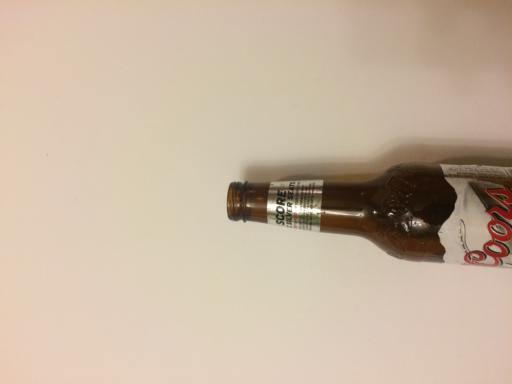

In [5]:
#Display a sample glass image
glass = list(data_dir.glob('glass/*'))
PIL.Image.open(str(glass[0]))

## Load Dataset

In [6]:
#Define some parameters for the loader:
batch_size = 32
img_height = 384
img_width = 512

#TODO: Resize to smaller size

In [7]:
# #clear images folder
folder = './images'
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

In [8]:
def train_test_split_folders(data_dir):
    splitfolders.ratio(data_dir, output="images", seed=1337, ratio=(.8, 0.1,0.1))
    image_dir = 'images'

    #create training split  
    train_ds = tf.keras.utils.image_dataset_from_directory(
    image_dir + '/train',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

    #create validation split
    val_ds = tf.keras.utils.image_dataset_from_directory(
    image_dir + '/val',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

    #create validation split
    test_ds = tf.keras.utils.image_dataset_from_directory(
    image_dir + '/test',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = train_test_split_folders(data_dir=data_dir)

Found 2019 files belonging to 6 classes.
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Found 251 files belonging to 6 classes.
Found 257 files belonging to 6 classes.


2023-02-24 11:31:05.180821: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-24 11:31:05.180941: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
#Show names of the found classes
class_names = train_ds.class_names
num_classes = len(class_names)

print(class_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


## Configure the ds

*Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:*

    - Ds.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
    
    - Dataset.prefetch overlaps data preprocessing and model execution while training.

*Interested readers can learn more about both methods, as well as how to cache data to disk in the Prefetching section of the Better performance with the tf.data API guide.*

## Standardize the data

In [10]:
# intializing rescaling layer to map onto data in the next step
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [11]:
# creating the normalized dataset
 
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in '[0, 1]'
print(np.min(first_image), np.max(first_image))

2023-02-24 11:31:05.344796: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


0.078431375 1.0


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

#load data into cache to reduce i/o
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Define Model 1

In [19]:
# Load the pre-trained model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(384, 512,  3))

# Freeze the layers
for layer in base_model.layers:
    layer.trainable = False

# Add a new layer
x = layers.Flatten()(base_model.output)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(num_classes, activation='softmax')(x)

# Create the model
model = tf.keras.models.Model(inputs=base_model.input, outputs=output)

In [20]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
# Train the model
history = model.fit(train_ds,
                    epochs=5,
                    validation_data=val_ds)

Epoch 1/5


/Users/maxi/dev/trashAI/.venv/lib/python3.10/site-packages/keras/backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-02-24 11:34:05.306944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


55/64 [========================>.....] - ETA: 28s - loss: 4.9457 - accuracy: 0.3316

In [ ]:
model.summary()

In [ ]:
date = datetime.today().strftime("%Y-%m-%d_%H-%M")

In [ ]:
# save as tlite model 
# Convert the model.
convert_model = True

if convert_model:
      with open("./models/trash_classes.txt", "wb") as f:
            for cls in train_ds.class_names:
                  f.write(cls + "\n")
      
      converter = tf.lite.TFLiteConverter.from_keras_model(model)
      tflite_model = converter.convert()

      # Save the model.
      with open(f'./models/transfer_model_tflite_{date}.tflite', 'wb') as f:
            f.write(tflite_model)

In [ ]:
# save model
save_model = False
if save_model:      
      model.save(f'./models/model_{date}')

In [ ]:
#export training history
save = False

if save:
    np.save('test2_history.npy',history.history)

In [ ]:
#import training history
load = False

if load:
    history=np.load('my_history.npy',allow_pickle='TRUE').item()

In [ ]:
def plot_history_acc(history):
    # summarize history for accuracy
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig('history_acc.png')
    
plot_history_acc(history)


In [ ]:
def plot_history_loss(history):
    # summarize history for loss
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig('history_loss.png')
    
plot_history_loss(history)

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
# TODO: Tensorboard
# TODO: Predict Sample image
# TODO: Model Optimizer implementieren (KERAS Tuner)

## Model 2

In [ ]:
# Load the pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(384, 512, 3))

# Freeze the layers
for layer in base_model.layers[:-1]:
    layer.trainable = False

# Add a new layer
x = layers.GlobalAveragePooling2D()(base_model.output)
output = layers.Dense(num_classes, activation='softmax')(x)

# Create the model
model = tf.keras.models.Model(inputs=base_model.input, outputs=output)

In [ ]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(train_ds,
                    epochs=5,
                    validation_data=val_ds)

In [ ]:
plot_history_acc(history)

In [ ]:
plot_history_loss(history)